In [ ]:
#This is a general classifcation template. The data used here is binary.. 
# a folder of all water NOAA images, and a folder of images that are not all water

In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math
from sklearn.metrics import confusion_matrix
import itertools

#Set GPU to use
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for file shuffler
import shutil
import random

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [ ]:
#randomly selecting files from the more frequent label (not_flooded in this case)
dirpath = 'data/all_data/not_flooded'
destDirectory = 'data/classification/not_flooded'

#replace 485 with number of flooded images
filenames = random.sample(os.listdir(dirpath), 485)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.copy(srcpath, destDirectory)

In [32]:
#build data generators for training and validaton

split = 0.2

# Define dirs and files
train_data_dir = 'data/classification'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.5,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset = 'training',
                                                    shuffle = True)

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation',
                                                        shuffle = True )

Found 304 images belonging to 2 classes.
Found 76 images belonging to 2 classes.


In [34]:
#load or build model
##########

#base_model, no top layer, w/ imagenet weights
#base_model = tf.keras.applications.VGG16(input_shape = imshape, 
#                                             include_top = False, 
#                                             weights = 'imagenet')

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = imshape, 
                                             include_top = True, 
                                             weights = 'imagenet',
                                             alpha = 1.3)

base_model.trainable = False

# add a new classifcation layer

#final layer for VGG16
#final_layer = base_model.get_layer('block5_pool')

#final layer for mobilenetv2
final_layer = base_model.get_layer('out_relu')

print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten(name='flatten')(final_base_output)
#x = layers.GlobalAveragePooling2D(name='GAP2D_1')(final_base_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4), name='dense_1')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5, name='dropout_1')(x)             

#x = layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-2), name='dense_2')(x)
# Add a dropout rate of 0.5
#x = layers.Dropout(0.5, name='dropout_2')(x)  

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid', name='dense_out')(x)           

model = Model(base_model.input, x) 
#############
model.summary()

shape of last layer is  (None, 7, 7, 1664)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 40  1080        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 40  160         ['Conv1[0][0]']                  
                                )                

 block_3_expand_relu (ReLU)     (None, 56, 56, 192)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 192)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 480)  38400       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 480)  1920       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 480)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 480)  4320       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 480)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 128)  61440       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 128)  512        ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 768)  98304       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 1248)  11232       ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 1248)  4992        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 1248)  0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 208)    259584      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [35]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [36]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4),
              metrics = acc_metric)

In [37]:
# define a callback, early stopping and learning rate reducer

earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.5,
                                                 verbose = 1,
                                                 patience = 5)

In [38]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    workers = 6,
                    epochs= 100,
                    callbacks =[earlystop, reducelr])

Epoch 1/100
19/19 [==============================] - 13s 509ms/step - loss: 6.5687 - acc: 0.6349 - val_loss: 5.7933 - val_acc: 0.5132 - lr: 3.0000e-04
Epoch 2/100
19/19 [==============================] - 9s 374ms/step - loss: 2.7848 - acc: 0.7467 - val_loss: 2.5250 - val_acc: 0.7105 - lr: 3.0000e-04
Epoch 3/100
19/19 [==============================] - 9s 367ms/step - loss: 1.9656 - acc: 0.7796 - val_loss: 2.2807 - val_acc: 0.6974 - lr: 3.0000e-04
Epoch 4/100
19/19 [==============================] - 9s 375ms/step - loss: 2.3183 - acc: 0.7303 - val_loss: 2.1822 - val_acc: 0.7368 - lr: 3.0000e-04
Epoch 5/100
19/19 [==============================] - 9s 382ms/step - loss: 2.0083 - acc: 0.7796 - val_loss: 0.9876 - val_acc: 0.8684 - lr: 3.0000e-04
Epoch 6/100
19/19 [==============================] - 9s 389ms/step - loss: 1.3887 - acc: 0.8059 - val_loss: 1.8036 - val_acc: 0.7105 - lr: 3.0000e-04
Epoch 7/100
19/19 [==============================] - 9s 392ms/step - loss: 1.4710 - acc: 0.7796 - v

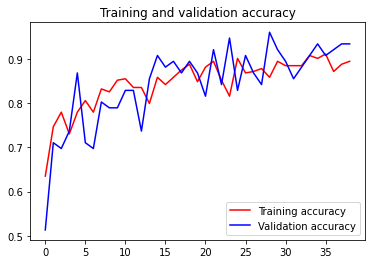

<Figure size 432x288 with 0 Axes>

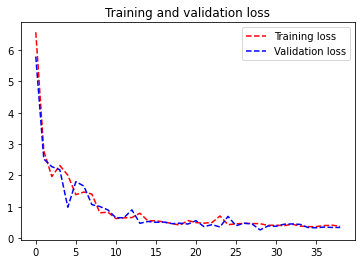

<Figure size 432x288 with 0 Axes>

In [39]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
#do predictions using model, prepare confusion matrix
val_labels = validation_generator.classes 
predictions = (model.predict(x=validation_generator, verbose=1) > 0.5).astype("int32")
cm = confusion_matrix(y_true=val_labels, y_pred=predictions)
validation_generator.class_indices

train_generator
train_labels = train_generator.classes
predictions_train = (model.predict(x=train_generator, verbose=1) > 0.5).astype("int32")
cm_train = confusion_matrix(y_true=train_labels, y_pred=predictions_train)
train_generator.class_indices

19/19 [==============================] - 18s 959ms/step


{'flooded': 0, 'not_flooded': 1}

In [ ]:
#confusion matrix of validation data
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Val Confusion Matrix')

Confusion matrix, without normalization
[[88 64]
 [72 80]]


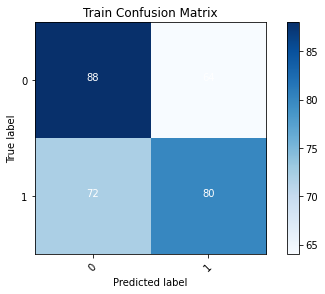

In [43]:
#confusion matrix of training data
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm_train, classes=cm_plot_labels, title='Train Confusion Matrix')

In [44]:
#save the model
filepath = './models/mobilenetv2_water_test9'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./models/mobilenetv2_water_test9\assets
